In [2]:
!pip install librosa -q


In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F
import librosa
import os
from torch.utils.data import Dataset
import pandas as pd


In [5]:
class VoiceToGuitarDataset(Dataset):
    def __init__(self, data_dir,voice_paths,guitar_paths, num_mels, hop_length):
        super(VoiceToGuitarDataset, self).__init__()
        self.data_dir = data_dir
        self.voice_paths = voice_paths
        self.guitar_paths = guitar_paths

        self.num_mels = num_mels
        self.hop_length = 512

    def _parse_voice_audio(self, audio_path):
        y, _ = librosa.load(audio_path, sr=16_000,duration=20)
        S = np.abs(librosa.stft(y, hop_length=self.hop_length, n_fft=self.hop_length*2))
        mel_spec = librosa.feature.melspectrogram(S=S, sr=16_000, n_mels=self.num_mels, hop_length=self.hop_length)


        return torch.FloatTensor(mel_spec[:,0:620])

    def _parse_guitar_audio(self, audio_path):
        y, _ = librosa.load(audio_path, sr=16_000,duration=20)
        S = np.abs(librosa.stft(y, hop_length=self.hop_length, n_fft=self.hop_length*2))
        mel_spec = librosa.feature.melspectrogram(S=S, sr=16_000, n_mels=self.num_mels, hop_length=self.hop_length)


        return torch.FloatTensor(mel_spec[:,0:620])

    def __getitem__(self, idx):
        voice = self._parse_voice_audio(os.path.join(self.data_dir,'voice_wav',self.voice_paths[idx]))
        guitar = self._parse_guitar_audio(os.path.join(self.data_dir,'guitar_wav',self.guitar_paths[idx]))
        
        return voice, guitar

    def __len__(self):
        return len(self.guitar_paths)

In [6]:
voice = os.listdir('/content/drive/MyDrive/DataSetVoice/voice_wav')
guitar = os.listdir('/content/drive/MyDrive/DataSetVoice/guitar_wav')
voice = sorted(voice)
guitar = sorted(guitar)
train_voice = voice[:int(len(voice)*0.8)]
train_guitar = guitar[:int(len(guitar)*0.8)]
test_voice = voice[len(train_voice):]
test_guitar = guitar[len(train_guitar):]
print(len(train_voice),len(train_guitar),len(test_voice),len(test_guitar))

82 82 21 21


In [7]:
dir = '/content/drive/MyDrive/DataSetVoice/'
train_dataset = VoiceToGuitarDataset(dir,train_voice, train_guitar, 256,512)
test_dataset = VoiceToGuitarDataset(dir,test_voice, test_guitar, 256,512)

In [8]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=5, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=5, num_workers=0)

In [9]:
def imshow(img):
    img = img / 2 + 0.5  
    plt.imshow(img) 

In [10]:
dataiter = iter(train_loader)
voice, guitar = dataiter.next()
voice = voice.numpy()
guitar = guitar.numpy()

In [11]:
voice.shape, guitar.shape

((5, 256, 620), (5, 256, 620))

IndexError: ignored

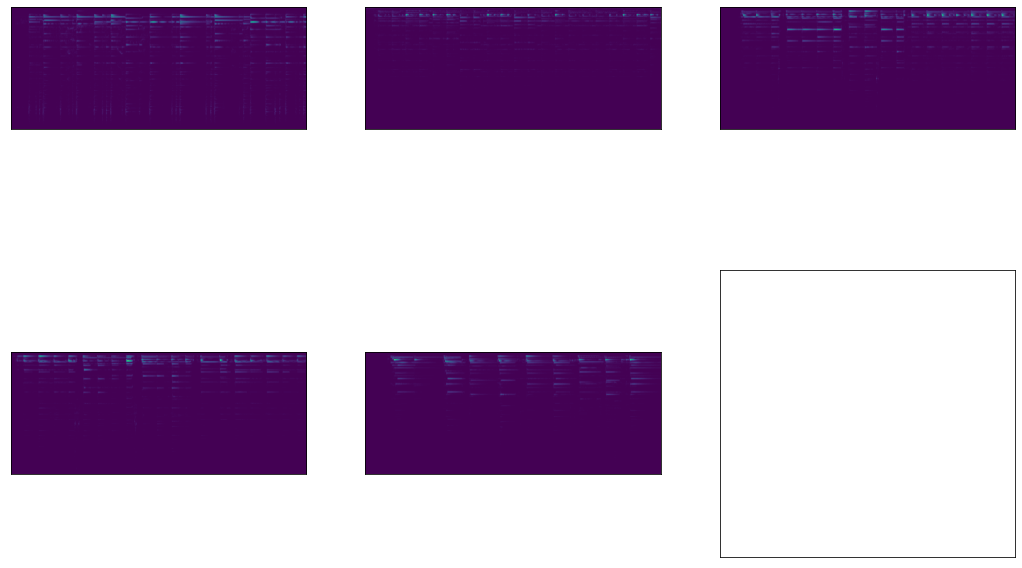

In [12]:
fig = plt.figure(figsize=(18, 18))
# display 20 images
for idx in np.arange(9):
    ax = fig.add_subplot(3, 3, idx+1, xticks=[], yticks=[])
    imshow(voice[idx])
    imshow(guitar[idx])
    # ax.set_title(classes[labels[idx]])

In [13]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
       
        #Encoder
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
       
        #Decoder
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.t_conv1(x))
        x = F.sigmoid(self.t_conv2(x))
              
        return x



In [14]:

model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)


In [15]:
#Loss function
criterion = nn.BCELoss()

#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [16]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)
model.to(device)

cuda:0


ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)

In [17]:
n_epochs = 100

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0

    #Training
    for data in train_loader:
        voice, guitar = data

        voice = voice.to(device)
        guitar = guitar.to(device)

        optimizer.zero_grad()
        outputs = model(voice.unsqueeze(1))

        loss = criterion(outputs, guitar.unsqueeze(1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*guitar.size(0)
          
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 2.422417
Epoch: 2 	Training Loss: 2.285491
Epoch: 3 	Training Loss: 2.002595
Epoch: 4 	Training Loss: 1.604550


KeyboardInterrupt: ignored

In [36]:
#Batch of test voices
dataiter = iter(test_loader)
voice, guitar = dataiter.next()

#Sample outputs
output = model(voice.unsqueeze(1).to(device))
voice = voice.numpy()
guitar = guitar.numpy()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [37]:
output.shape

torch.Size([5, 1, 256, 620])

In [38]:
output = output.view(5, 1, 256, 620)


In [39]:
output = output.squeeze(1).cpu().detach().numpy()

In [40]:
output.shape

(5, 256, 620)

Original Guitar


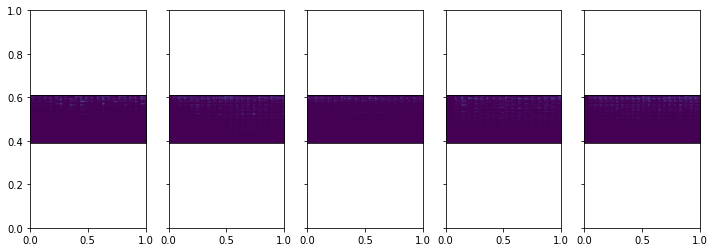

Reconstructed Guitar


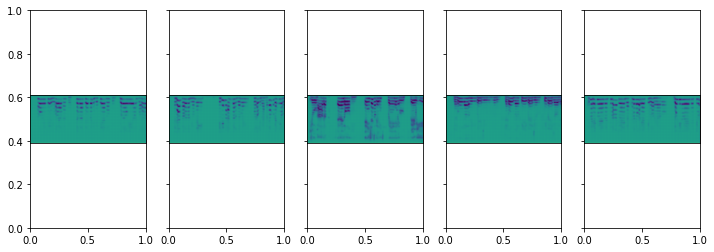

In [41]:
#Original Images
print("Original Guitar")
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(guitar[idx])
plt.show()

#Reconstructed Images
print('Reconstructed Guitar')
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(output[idx])
plt.show() 

In [42]:
sr = 16_000
n_mels = 256
hop_length = 512
n_iter = 32
S_inv = librosa.feature.inverse.mel_to_stft(output[0], sr=16_000, n_fft=hop_length*4)
y_inv = librosa.griffinlim(S_inv, n_iter=n_iter,
                            hop_length=hop_length)

In [43]:
S_inv = librosa.feature.inverse.mel_to_stft(guitar[0], sr=16_000, n_fft=hop_length*4)
orig = librosa.griffinlim(S_inv, n_iter=n_iter,
                            hop_length=hop_length)

In [44]:
import soundfile
soundfile.write(dir+'inv.wav', y_inv, samplerate=sr)
soundfile.write(dir+'orig.wav', orig, samplerate=sr)
